#Install the SAM2 Library

In [ ]:
!pip install sam2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.3 MB/s eta 0:00:00
  Created wheel for sam2: filename=sam2-0.4.1-cp310-cp310-linux_x86_64.whl size=85850 sha256=932541c9af814cd888ea80d60bea2d52321d7340407ca577395a29dda97fdc77
  Stored in directory: /root/.cache/pip/wheels/f7/24/19/6ae406a45571a7fed8ef81297fc11698486638ac21200cdafa
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=

In [2]:
#checking sam2 install
from sam2 import *

Downloading the data and models

In [ ]:
!wget https://huggingface.co/facebook/sam2-hiera-tiny/resolve/75e967a96dea6297b3bbf66ce030a4eb3e2b3db4/sam2_hiera_tiny.pt
!wget https://huggingface.co/facebook/sam2-hiera-tiny/resolve/main/sam2_hiera_t.yaml
!wget https://www.cs.cmu.edu/~ehsiao/3drecognition/CMU10_3D.zip

In [3]:
!ls /content/

CMU10_3D.zip  sam2_hiera_tiny.pt  sam2_hiera_t.yaml  sample_data


In [5]:
# unzip the dataset I have hiddent he output just for simplification.
!unzip CMU10_3D.zip

Archive:  CMU10_3D.zip
   creating: CMU10_3D/
  inflating: CMU10_3D/README.txt     
   creating: CMU10_3D/data_3D/
   creating: CMU10_3D/modelimages/
   creating: CMU10_3D/data_2D/
  inflating: CMU10_3D/data_3D/carton_oj_000009.jpg  
  inflating: CMU10_3D/data_3D/rice_tuscan_000004.jpg  
  inflating: CMU10_3D/data_3D/camera.txt  
  inflating: CMU10_3D/data_3D/can_soymilk_000005.jpg  
  inflating: CMU10_3D/data_3D/carton_soymilk_3Dgt.txt  
  inflating: CMU10_3D/data_3D/diet_coke_000009.jpg  
  inflating: CMU10_3D/data_3D/carton_soymilk_000002.jpg  
  inflating: CMU10_3D/data_3D/rice_tuscan_000009.jpg  
  inflating: CMU10_3D/data_3D/can_soymilk_000011.jpg  
  inflating: CMU10_3D/data_3D/can_chowder_000004.jpg  
  inflating: CMU10_3D/data_3D/hc_potroastsoup_000004.jpg  
  inflating: CMU10_3D/data_3D/can_tomatosoup_000005.jpg  
  inflating: CMU10_3D/data_3D/diet_coke_000002.jpg  
  inflating: CMU10_3D/data_3D/juicebox_000008.jpg  
  inflating: CMU10_3D/data_3D/can_tomatosoup_3Dgt.txt  
  i

Processing an image -->  I am creating this function to create bouding box on the image using its mask. then in the end visulaize the image.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def process_img_png_mask(image_path, mask_path, visualize=False):
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        xmin, xmax, ymin, ymax = x, x+w, y, y+h
    else:
        xmin, xmax, ymin, ymax = 0, 0, 0, 0

    if visualize:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        plt.imshow(image)
        plt.title("Bounding Box on Image")
        plt.show()

    return xmin, xmax, ymin, ymax


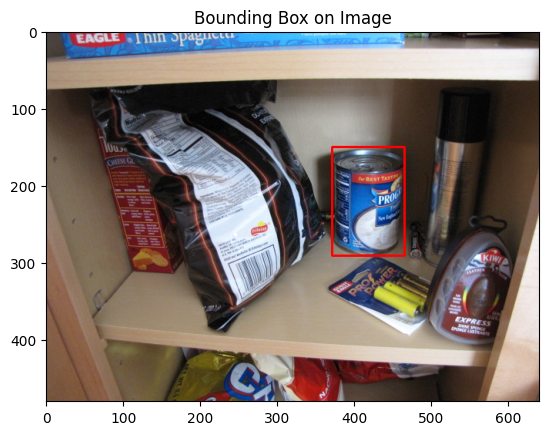

In [ ]:
firstimgpath = '/content/CMU10_3D/data_2D/can_chowder_000001.jpg'
firstimgmaskpath = '/content/CMU10_3D/data_2D/can_chowder_000001_1_gt.png'
[xmin,xmax,ymin,ymax] = process_img_png_mask(firstimgpath,firstimgmaskpath,visualize = True)

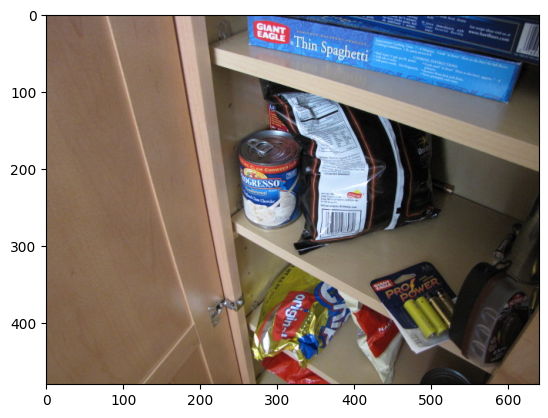

In [ ]:
# just checking the second image for the product.
secondimgpath = '/content/CMU10_3D/data_2D/can_chowder_000002.jpg'
secondimg = Image.open(secondimgpath)
plt.imshow(secondimg)
plt.show()

#Detection and Accuracy Approach
1. Import the required functom SAM2 Library
2. Loading the model(sam2_hiera_tiny) and config file.
3. Creating the predictor instance
4. a. load_reference_data --> to load the first image and corresponding mask.
  
  b. load_test_images --> Load the relevent images as test images for a particular product.

  c. detect_products --> Detection by setting up the refrence image as predictor then detecting the mask for each test image for a particular product.
  
  d. Calculating the accuracy by comapririnthe detected mask against given mask in ground truth



In [ ]:
import os
import numpy as np
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Model Loading
checkpoint = "./sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"
sam2 = build_sam2(model_cfg, checkpoint, device='cpu', apply_postprocessing=False)
predictor = SAM2ImagePredictor(sam2)

# Load reference data
def load_reference_data(reference_image_path, reference_mask_path):
    reference_image = Image.open(reference_image_path).convert("RGB")
    reference_mask = Image.open(reference_mask_path).convert("L")  # Load mask as grayscale
    return np.array(reference_image), np.array(reference_mask)

# Load test images from a folder
def load_test_images(folder_path):
    test_images = []
    test_image_names = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):  # Adjust based on your test image format
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert("RGB")
            test_images.append((filename, np.array(img)))  # Store name and image array

    return test_images

# Detect products in test images
def detect_products(reference_image, reference_mask, test_images):
    detections = []

    predictor.set_image(reference_image)
    point_coords = np.array([[0, 0]])
    point_labels = np.array([1])

    for name, img in test_images:
        predictor.set_image(img)
        detection = predictor.predict(point_coords=point_coords, point_labels=point_labels)

        if detection is not None and isinstance(detection, tuple) and len(detection) > 0:
            detected_mask = detection[0]
            detections.append((name, detected_mask))  # Store the name with its detected mask
        else:
            print(f"Warning: No valid mask found for {name}. Skipping this image.")

    return detections

# Calculate accuracy based on ground truth masks
def calculate_accuracy(detections, reference_mask):
    correct_predictions = 0
    total_pixels = 0

    for name, detected_mask in detections:

        detected_mask = np.round(detected_mask).astype(int)  # Round the mask to binary (0 or 1)
        reference_mask = reference_mask.astype(int)  # Ensure reference mask is binary too
        detected_mask_resized = resize_mask(detected_mask, reference_mask)
        correct_predictions += np.sum(detected_mask_resized.flatten() == reference_mask.flatten())
        total_pixels += reference_mask.size

    return correct_predictions / total_pixels if total_pixels > 0 else 0

def resize_mask(detected_mask, reference_mask):
    if len(detected_mask.shape) > 2:
        detected_mask = detected_mask[:, :, 0]
    detected_mask = detected_mask.astype(np.uint8)

    # Ensure reference_mask is also uint8 and 2D
    reference_mask = np.squeeze(reference_mask).astype(np.uint8)

    # Convert detected mask to PIL image
    detected_mask_img = Image.fromarray(detected_mask)

    # Resize detected_mask to match reference_mask's size
    reference_mask_img = Image.fromarray(reference_mask)
    resized_detected_mask = detected_mask_img.resize(reference_mask_img.size, Image.NEAREST)

    # Convert resized mask back to numpy array
    return np.array(resized_detected_mask)



# Main execution
folder_path = "/content/CMU10_3D/data_2D"
products = {}
product_done = set()
# Identify unique product names
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        product_name = filename.split('_0')[0]
        if product_name   not in product_done:
          product_done.add(product_name)
          reference_image_path = os.path.join(folder_path, filename)
          #  Find the corresponding mask files
          mask_files = [f for f in os.listdir(folder_path) if f.startswith(product_name) and f.endswith("_gt.png")]
          print(mask_files)
          if mask_files:
              reference_mask_path = os.path.join(folder_path, mask_files[0])  # Load the first mask found
              reference_image, reference_mask = load_reference_data(reference_image_path, reference_mask_path)
              products[product_name] = (reference_image, reference_mask)

# Load test images
test_images = load_test_images(folder_path)

#  Process each product
for product_name, (reference_image, reference_mask) in products.items():
    print(f"Processing product: {product_name}")
    relevant_test_images = [img for img in test_images if product_name in img[0]]
    detections = detect_products(reference_image, reference_mask, relevant_test_images)

    #  Calculate accuracy
    if len(detections) > 0:
        accuracy = calculate_accuracy(detections, reference_mask)
        print(f"Accuracy for {product_name}: {accuracy * 100:.2f}%")
    else:
        print(f"No valid detections for {product_name}.")
    print(f"Accuracy for {product_name}: {accuracy * 100:.2f}%")


['carton_soymilk_000038_2_gt.png', 'carton_soymilk_000005_1_gt.png', 'carton_soymilk_000017_2_gt.png', 'carton_soymilk_000014_1_gt.png', 'carton_soymilk_000019_1_gt.png', 'carton_soymilk_000004_1_gt.png', 'carton_soymilk_000045_1_gt.png', 'carton_soymilk_000037_2_gt.png', 'carton_soymilk_000042_1_gt.png', 'carton_soymilk_000024_1_gt.png', 'carton_soymilk_000033_1_gt.png', 'carton_soymilk_000022_1_gt.png', 'carton_soymilk_000015_1_gt.png', 'carton_soymilk_000032_1_gt.png', 'carton_soymilk_000012_1_gt.png', 'carton_soymilk_000013_1_gt.png', 'carton_soymilk_000046_2_gt.png', 'carton_soymilk_000003_1_gt.png', 'carton_soymilk_000016_1_gt.png', 'carton_soymilk_000019_2_gt.png', 'carton_soymilk_000046_1_gt.png', 'carton_soymilk_000050_2_gt.png', 'carton_soymilk_000043_2_gt.png', 'carton_soymilk_000038_1_gt.png', 'carton_soymilk_000011_1_gt.png', 'carton_soymilk_000041_1_gt.png', 'carton_soymilk_000011_2_gt.png', 'carton_soymilk_000008_1_gt.png', 'carton_soymilk_000021_2_gt.png', 'carton_soymi